In [1]:
import sys
sys.path.append("/workspace/es-bench/preprocess")

In [39]:
from argparse import ArgumentParser
from pathlib import Path
import re

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, FloatType, TimestampType, StringType, StructField, StructType, ArrayType
from pyspark.ml.feature import Bucketizer
from pyspark.sql import Window

from common import cat_freq, collect_lists, train_test_split

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [6]:
DATA_PATH = Path("../../data/mimic-3/files/mimiciii/1.4/")
FIGS_PATH = Path("figures/mimic-iii/")

# Prepare data

In [4]:
spark = SparkSession.builder.master("local[32]").getOrCreate()

Picked up _JAVA_OPTIONS: -Xmx32g
Picked up _JAVA_OPTIONS: -Xmx32g
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 06:25:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Target

In [7]:
df_adm = spark.read.csv((DATA_PATH / "ADMISSIONS.csv.gz").as_posix(), header=True).select(
    F.col("HADM_ID").cast(LongType()).alias("hadm_id"),
    (
        (
            F.col("DISCHTIME").cast(TimestampType()) 
            - F.col("ADMITTIME").cast(TimestampType())
        ).cast(LongType())
        / 3600
    ).alias("length_of_stay"),
    F.col("HOSPITAL_EXPIRE_FLAG").cast(LongType()).alias("hospital_expire_flag")
)
df_adm.show()

+-------+------------------+--------------------+
|hadm_id|    length_of_stay|hospital_expire_flag|
+-------+------------------+--------------------+
| 165315|27.466666666666665|                   0|
| 152223|131.91666666666666|                   0|
| 124321|162.43333333333334|                   0|
| 161859| 68.56666666666666|                   0|
| 129635| 84.81666666666666|                   0|
| 197661|167.73333333333332|                   0|
| 134931| 64.48333333333333|                   0|
| 162569|            128.75|                   0|
| 104557|120.33333333333333|                   0|
| 128652|            183.55|                   1|
| 175413|            460.75|                   0|
| 176176| 85.58333333333333|                   0|
| 115799|47.233333333333334|                   0|
| 144319|             62.95|                   0|
| 166707|            244.25|                   0|
| 182104|            198.75|                   0|
| 122659|305.68333333333334|                   0|


## Common features

In [18]:
# from https://github.com/mlds-lab/interp-net/blob/master/src/mimic_data_extraction.py

itemid_feats = """
SpO2 - 646, 220277
HR - 211, 220045
RR - 618, 615, 220210, 224690
SBP - 51,442,455,6701,220179,220050
DBP - 8368,8440,8441,8555,220180,220051
Temp(F) - 223761,678
Temp(C) - 223762,676
TGCS - 198, 226755, 227013
CRR - 3348, 115, 223951, 8377, 224308
Urine Output - 40405, 40428, 41857, 42001, 42362, 42676, 43171, 43173, 42042, 42068, 42111, 42119, 40715, 40056, 40061, 40085, 40094, 40096, 43897, 43931, 43966, 44080, 44103, 44132, 44237, 43348, 43355, 43365, 43372, 43373, 43374, 43379, 43380, 43431, 43462, 43522, 44706, 44911, 44925, 42810, 42859, 43093, 44325, 44506, 43856, 45304, 46532, 46578, 46658, 46748, 40651, 40055, 40057, 40065, 40069, 44752, 44824, 44837, 43576, 43589, 43633, 43811, 43812, 46177, 46727, 46804, 43987, 44051, 44253, 44278, 46180, 45804, 45841, 45927, 42592, 42666, 42765, 42892, 43053, 43057, 42130, 41922, 40473, 43333, 43347, 44684, 44834, 43638, 43654, 43519, 43537, 42366, 45991, 43583, 43647, 45415, 227519
FiO2 - 2981, 3420, 3422, 223835
Glucose - 807,811,1529,3745,3744,225664,220621,226537
pH - 780, 860, 1126, 1673, 3839, 4202, 4753, 6003, 220274, 220734, 223830, 228243
"""

In [19]:
data = []
for row in itemid_feats.strip().split("\n"):
    feature_name, ids_str = row.split(" - ")
    ids = list(map(int, ids_str.split(",")))
    data.append([feature_name, ids])

In [20]:
pdf_features = (
    pd.DataFrame(columns=["feature_name", "itemid"], data=data)
    .explode("itemid", ignore_index=True)
)
pdf_features

,feature_name,itemid
0,SpO2,646
1,SpO2,220277
2,HR,211
3,HR,220045
4,RR,618
...,...,...
148,pH,6003
149,pH,220274
150,pH,220734
151,pH,223830


In [21]:
df_features = spark.createDataFrame(pdf_features)
df_features.printSchema()
df_features.show()

root
 |-- feature_name: string (nullable = true)
 |-- itemid: long (nullable = true)



+------------+------+
|feature_name|itemid|
+------------+------+
|        SpO2|   646|
|        SpO2|220277|
|          HR|   211|
|          HR|220045|
|          RR|   618|
|          RR|   615|
|          RR|220210|
|          RR|224690|
|         SBP|    51|
|         SBP|   442|
|         SBP|   455|
|         SBP|  6701|
|         SBP|220179|
|         SBP|220050|
|         DBP|  8368|
|         DBP|  8440|
|         DBP|  8441|
|         DBP|  8555|
|         DBP|220180|
|         DBP|220051|
+------------+------+
only showing top 20 rows



In [22]:
feature_names = pdf_features.feature_name.unique().tolist()
feature_names

['SpO2',
 'HR',
 'RR',
 'SBP',
 'DBP',
 'Temp(F)',
 'Temp(C)',
 'TGCS',
 'CRR',
 'Urine Output',
 'FiO2',
 'Glucose',
 'pH']

## Filter the features

In [24]:
df_values = spark.read.csv((DATA_PATH / "CHARTEVENTS.csv.gz").as_posix(), header=True).select(
    F.col("HADM_ID").cast(LongType()).alias("hadm_id"),
    F.col("CHARTTIME").cast(TimestampType()).alias("charttime"),
    F.col("ITEMID").cast(LongType()).alias("itemid"),
    F.col("VALUE").alias("value"),
)
df_values.show()

+-------+-------------------+------+-----+
|hadm_id|          charttime|itemid|value|
+-------+-------------------+------+-----+
| 165660|2134-05-12 12:00:00|223834|   15|
| 165660|2134-05-12 12:00:00|223835|  100|
| 165660|2134-05-12 12:00:00|224328|  .37|
| 165660|2134-05-12 12:00:00|224329|    6|
| 165660|2134-05-12 12:00:00|224330|  2.5|
| 165660|2134-05-12 12:00:00|224331|    0|
| 165660|2134-05-12 12:00:00|224332|    3|
| 165660|2134-05-12 12:00:00|224663|    8|
| 165660|2134-05-12 12:00:00|224665| 1.11|
| 165660|2134-05-12 12:35:00|220224|   58|
| 165660|2134-05-12 12:35:00|220235|   60|
| 165660|2134-05-12 12:35:00|223830| 7.29|
| 165660|2134-05-12 12:35:00|224828|    0|
| 165660|2134-05-12 12:35:00|225668|    1|
| 165660|2134-05-12 12:35:00|225698|   30|
| 165660|2134-05-12 13:00:00|220045|   86|
| 165660|2134-05-12 13:00:00|220179|  137|
| 165660|2134-05-12 13:00:00|220180|   72|
| 165660|2134-05-12 13:00:00|220181|   84|
| 165660|2134-05-12 13:00:00|220210|   21|
+-------+--

In [25]:
%%time

df_values = df_values.join(df_features, on="itemid").drop("itemid").cache()
df_values.printSchema()
df_values.show()

root
 |-- hadm_id: long (nullable = true)
 |-- charttime: timestamp (nullable = true)
 |-- value: string (nullable = true)
 |-- feature_name: string (nullable = true)



+-------+-------------------+-----+------------+
|hadm_id|          charttime|value|feature_name|
+-------+-------------------+-----+------------+
| 141647|2183-08-24 08:00:00|   76|         DBP|
| 141647|2183-08-24 09:12:00|   67|         DBP|
| 193281|2140-04-13 11:00:00|  124|         DBP|
| 172593|2164-03-07 12:00:00|   35|         DBP|
| 120589|2162-02-01 16:00:00|   32|         DBP|
| 172260|2124-11-15 09:00:00|   46|         DBP|
| 172260|2124-11-15 10:00:00|   52|         DBP|
| 172260|2124-11-15 11:00:00|   42|         DBP|
| 172260|2124-11-15 12:00:00|   48|         DBP|
| 172260|2124-11-15 14:15:00|   40|         DBP|
| 139824|2168-03-30 07:00:00|   60|         DBP|
| 139824|2168-03-30 03:30:00|   60|         DBP|
| 127036|2199-10-11 10:45:00|   74|         DBP|
| 127036|2199-10-11 11:00:00|   73|         DBP|
| 160548|2137-09-30 22:00:00|   56|         DBP|
| 186516|2148-12-02 22:00:00|   56|         DBP|
| 153771|2166-07-24 23:00:00|   80|         DBP|
| 173307|2113-10-26 

In [27]:
# df_values.coalesce(1).write.parquet("values.parquet")

In [28]:
df_pivoted = (
    df_values.groupBy("hadm_id", "charttime")
    .pivot("feature_name", feature_names)
    .agg(F.any_value("value", ignoreNulls=True))
)

In [31]:
%%time
pdf = df_pivoted.toPandas()
pdf

CPU times: user 14min 56s, sys: 1min, total: 15min 56s
Wall time: 16min 5s


,hadm_id,charttime,SpO2,HR,RR,SBP,DBP,Temp(F),Temp(C),TGCS,CRR,Urine Output,FiO2,Glucose,pH
0,100001,2117-09-11 18:00:00,98,112,16,170,86,None,None,None,None,None,None,172,None
1,100001,2117-09-11 20:00:00,97,116,None,183,91,None,None,None,None,None,None,191,None
2,100001,2117-09-13 05:00:00,None,123,None,None,None,None,None,None,None,None,None,None,None
3,100001,2117-09-14 00:00:00,None,111,None,None,None,99.4,None,None,None,None,None,172,None
4,100001,2117-09-15 01:00:00,None,107,None,140,85,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9575556,199994,2188-07-10 09:00:00,98,65,10,97,48,None,None,None,None,None,None,None,None
9575557,199994,2188-07-11 09:00:00,95,72,None,96,48,None,None,None,None,None,None,None,None
9575558,199994,2188-07-12 12:54:00,None,None,None,None,None,None,None,None,None,None,None,None,7.25
9575559,199995,2137-12-21 19:00:00,96,112,20,119,68,None,None,None,None,None,None,156,None


In [34]:
# pdf.to_parquet("pdf_values.parquet")

# Analysis

In [35]:
feature_names

['SpO2',
 'HR',
 'RR',
 'SBP',
 'DBP',
 'Temp(F)',
 'Temp(C)',
 'TGCS',
 'CRR',
 'Urine Output',
 'FiO2',
 'Glucose',
 'pH']

## SpO2 

Blood saturation. Should be close to 100.

In [56]:
vals = pdf["SpO2"].astype(float)
vals

0          98.0
1          97.0
2           NaN
3           NaN
4           NaN
           ... 
9575556    98.0
9575557    95.0
9575558     NaN
9575559    96.0
9575560    97.0
Name: SpO2, Length: 9575561, dtype: float64

In [42]:
vals.count() / len(vals)

0.6342585045408827

In [45]:
vals.describe()

count    6.073381e+06
mean     9.885929e+01
std      2.941947e+03
min      0.000000e+00
25%      9.600000e+01
50%      9.800000e+01
75%      9.900000e+01
max      6.363333e+06
Name: SpO2, dtype: float64

In [52]:
np.quantile(vals.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([  2.,  59.,  87.,  94., 100., 100., 100., 100.])

## HR

Heart rate. Maximal heart rate is approzimately 220 - age in years.

In [58]:
vals = pdf["HR"].astype(float)
vals

0          112.0
1          116.0
2          123.0
3          111.0
4          107.0
           ...  
9575556     65.0
9575557     72.0
9575558      NaN
9575559    112.0
9575560    107.0
Name: HR, Length: 9575561, dtype: float64

In [61]:
vals.count() / len(vals)

0.8274759045449138

In [62]:
np.quantile(vals.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([  0.,  38.,  52.,  67., 157., 178., 190., 203.])

## RR

Respiratory rate. Rate at which breathing occurs. 12 - 15 is normal.

In [66]:
vals = pdf["RR"]
vals

0            16
1          None
2          None
3          None
4          None
           ... 
9575556      10
9575557    None
9575558    None
9575559      20
9575560      20
Name: RR, Length: 9575561, dtype: object

In [70]:
(vals.str.isnumeric() == False).sum() / len(vals)

5.430491226571477e-05

In [71]:
vals = vals.where(vals.str.isnumeric() != False, other=None).astype(float)
vals

0          16.0
1           NaN
2           NaN
3           NaN
4           NaN
           ... 
9575556    10.0
9575557     NaN
9575558     NaN
9575559    20.0
9575560    20.0
Name: RR, Length: 9575561, dtype: float64

In [72]:
vals.count() / len(vals)

0.6568550918322175

In [74]:
np.quantile(vals.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([ 0.,  0.,  7., 13., 28., 37., 48., 70.])

## SBP and DBP

Blood pressure is usually expressed in terms of the systolic pressure (maximum pressure during one heartbeat) over diastolic pressure (minimum pressure between two heartbeats) in the cardiac cycle.

In [77]:
sbp = pdf["SBP"].astype(float)
dbp = pdf["DBP"].astype(float)

In [78]:
print(sbp.count() / len(sbp))
print(dbp.count() / len(dbp))

0.6030635698524609
0.6028833193167481


In [79]:
(sbp < dbp).sum()

3979

In [80]:
bp = pd.DataFrame({"s": sbp, "d": dbp})
bp

,s,d
0,170.0,86.0
1,183.0,91.0
2,NaN,NaN
3,NaN,NaN
4,140.0,85.0
...,...,...
9575556,97.0,48.0
9575557,96.0,48.0
9575558,NaN,NaN
9575559,119.0,68.0


In [81]:
bp.query("s < d")

,s,d
2457,0.0,92.0
4840,0.0,65.0
5351,0.0,43.0
6229,4.0,51.0
7824,89.0,119.0
...,...,...
9567210,117.0,139.0
9567842,0.0,25.0
9569568,11.0,54.0
9573380,126.0,130.0


In [85]:
len(bp.query("s < d")) / len(bp)

0.0004155370113563059

In [83]:
print(np.quantile(sbp.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999]))
print(np.quantile(dbp.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999]))

[  0.  29.  74.  94. 153. 184. 210. 243.]
[  0.       0.      31.      44.      79.     102.     133.     203.7055]


## Temp

In [95]:
temp = pd.DataFrame({"f": pdf["Temp(F)"], "c": pdf["Temp(C)"]}).astype(float)
temp

,f,c
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,99.400000,NaN
4,NaN,NaN
...,...,...
9575556,NaN,NaN
9575557,NaN,NaN
9575558,NaN,NaN
9575559,NaN,NaN


In [96]:
temp.count() / len(pdf)

f    0.13475
c    0.04642
dtype: float64

<Axes: ylabel='Density'>

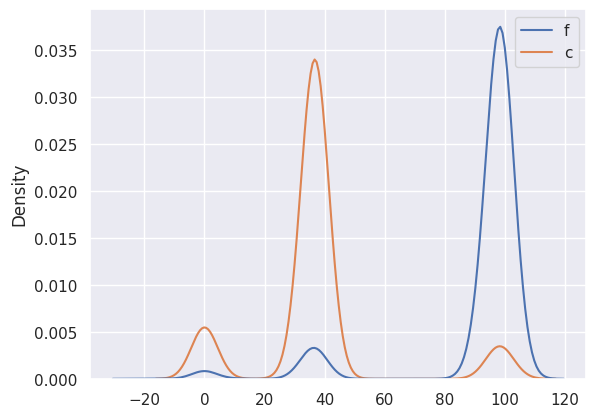

In [97]:
sns.kdeplot(temp.query("f < 200 and c < 200"))

In [100]:
temp.notna().sum(1).value_counts()

0    7843713
1    1728894
2       2954
Name: count, dtype: int64

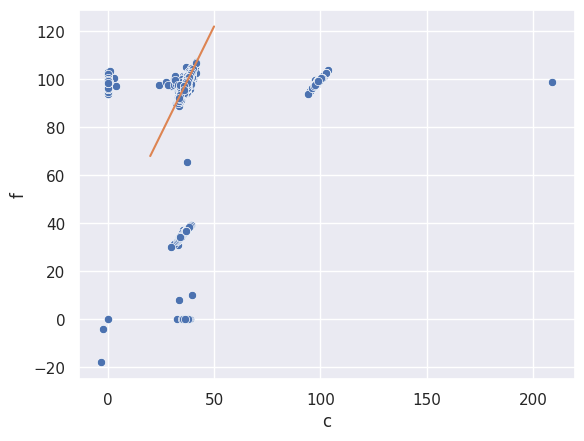

In [106]:
_, ax = plt.subplots()
sns.scatterplot(temp[temp.notna().sum(1) == 2], x="c", y="f", ax=ax)

c = np.linspace(20, 50, 100)
f = c * 9 / 5 + 32
ax.plot(c, f, c="C1")

## TGCS

Glasgow Coma Scale — between 3 and 15. 
Treat other as missing.
Highly likely missing should be treated as OK (15).

In [107]:
vals = pdf["TGCS"]
vals

0          None
1          None
2          None
3          None
4          None
           ... 
9575556    None
9575557    None
9575558    None
9575559    None
9575560    None
Name: TGCS, Length: 9575561, dtype: object

In [111]:
vals[vals.notna()].value_counts()

TGCS
15    356373
11    114225
10    101801
14     75050
3      59935
9      57442
8      47922
7      42996
6      35981
13     24250
12      9956
4       8769
5       7318
0          5
48         2
29         2
1          1
2          1
24         1
Name: count, dtype: int64

<Axes: xlabel='TGCS', ylabel='Density'>

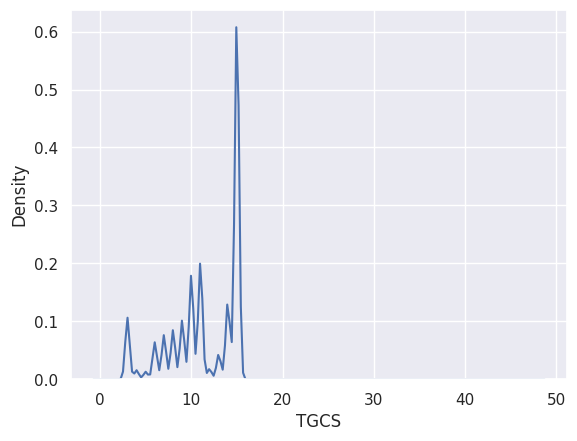

In [113]:
sns.kdeplot(vals.astype(float))

In [196]:
vals = pdf["CRR"]
vals

0          None
1          None
2          None
3          None
4          None
           ... 
9575556    None
9575557    None
9575558    None
9575559    None
9575560    None
Name: CRR, Length: 9575561, dtype: object

In [197]:
vals.count() / len(vals)

0.06315452431455452

In [198]:
vals.dropna()

46                     Brisk
51                     Brisk
55                     Brisk
77         Normal <3 Seconds
78         Normal <3 Seconds
                 ...        
9575477                Brisk
9575482                Brisk
9575487                Brisk
9575494                Brisk
9575548       Normal <3 secs
Name: CRR, Length: 604740, dtype: object

In [199]:
vals.value_counts()

CRR
Brisk                  438072
Normal <3 Seconds      140576
Normal <3 secs          16454
Abnormal >3 Seconds      6018
Delayed                  1747
Abnormal >3 secs         1692
Other/Remarks              93
Comment                    88
Name: count, dtype: int64

## Urine Output

In [114]:
vals = pdf["Urine Output"]
vals

0          None
1          None
2          None
3          None
4          None
           ... 
9575556    None
9575557    None
9575558    None
9575559    None
9575560    None
Name: Urine Output, Length: 9575561, dtype: object

In [115]:
vals.count() / len(vals)

8.354601887033041e-07

Just drop it

## FiO2

Fraction of inspired oxygen.
0.21 for natural air.
Gas with increased fraction of oxygen may be used in intensive care.

In [120]:
vals = pdf["FiO2"].astype(float)
vals

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
9575556   NaN
9575557   NaN
9575558   NaN
9575559   NaN
9575560   NaN
Name: FiO2, Length: 9575561, dtype: float64

In [121]:
vals.count() / len(vals)

0.12802163758342722

In [122]:
vals.min(), vals.max()

(0.0, 10050.0)

In [123]:
np.quantile(vals.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([  0.,   3.,  21.,  21., 100., 100., 100., 100.])

<Axes: xlabel='FiO2', ylabel='Density'>

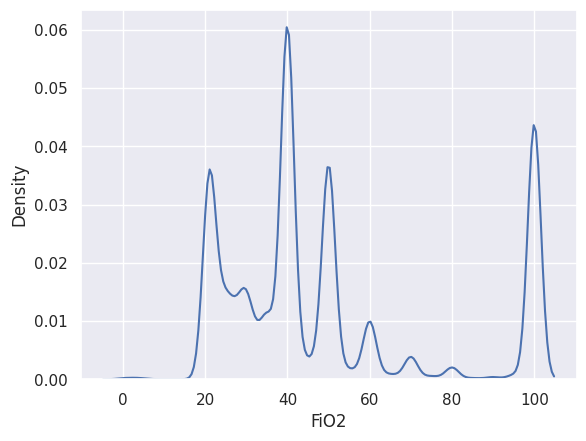

In [124]:
sns.kdeplot(vals[vals <= 100])

## Glucose

Blood sugar level

In [127]:
vals = pdf["Glucose"]
vals

0           172
1           191
2          None
3           172
4          None
           ... 
9575556    None
9575557    None
9575558    None
9575559     156
9575560    None
Name: Glucose, Length: 9575561, dtype: object

In [128]:
vals.count() / len(vals)

0.13291513677370967

In [129]:
(vals.str.isnumeric() == False).sum() / len(vals)

0.0007917029613199686

In [130]:
vals[vals.str.isnumeric() == False]

1245        258cs
2499        CS142
4934       CS 132
6167        cs191
7678        CS162
            ...  
9572195     110cs
9572693     cs140
9573323     126cs
9573603      99cs
9573668    CS 132
Name: Glucose, Length: 7581, dtype: object

In [141]:
vals_replaced = vals.str.lower().str.replace("cs", "").str.strip()

In [142]:
vals_replaced[vals_replaced.str.isnumeric() == False]

27498         '117
50520       4urssi
53068      2 units
90567       fs 223
142118       error
            ...   
9530669      171fs
9530990       -233
9532290      2ureg
9563402      149fs
9570711    no data
Name: Glucose, Length: 791, dtype: object

In [143]:
vals_replaced = vals_replaced.where(vals_replaced.str.isnumeric() != False).astype(float)

In [146]:
np.quantile(vals_replaced.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([  0.   ,  34.   ,  59.   ,  90.   , 203.   , 348.   , 501.   ,
       933.222])

<Axes: xlabel='Glucose', ylabel='Density'>

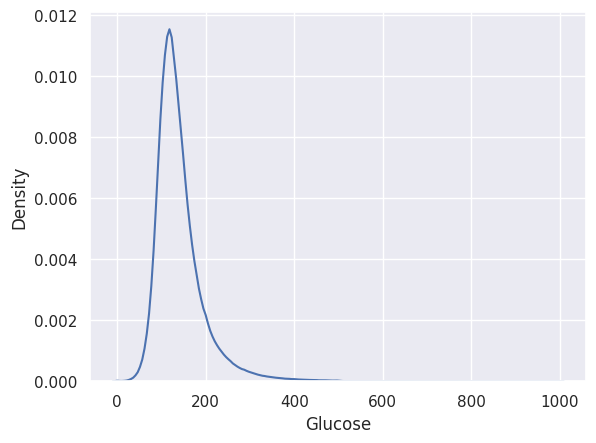

In [151]:
sns.kdeplot(vals_replaced[vals_replaced < 1000])

<Axes: xlabel='Glucose', ylabel='Density'>

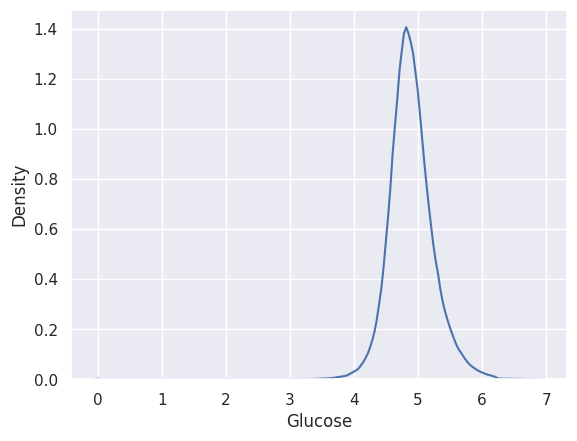

In [152]:
sns.kdeplot(np.log1p(vals_replaced[vals_replaced < 1000]))

Better to log-transform it. 0 to NaN

## pH

Blood pH. Normally aroung 7.40

In [157]:
vals = pdf["pH"]
vals

0          None
1          None
2          None
3          None
4          None
           ... 
9575556    None
9575557    None
9575558    7.25
9575559    None
9575560    None
Name: pH, Length: 9575561, dtype: object

In [158]:
vals.count() / len(vals)

0.04976042656926315

In [161]:
vals[vals.str.isnumeric() == False]

69         7.33
72         7.38
75         7.43
99         7.41
131        7.35
           ... 
9575458     7.4
9575522    7.38
9575533    7.38
9575538    7.43
9575558    7.25
Name: pH, Length: 464532, dtype: object

In [169]:
invalid = vals.apply(pd.to_numeric, errors='coerce').isna()

In [170]:
vals[invalid].dropna()

44749      no data
58090            .
162261     albuter
191840           .
373611        sent
            ...   
9359186    Alb/Atr
9380016          .
9382593    abg drw
9449025      ERROR
9543979      ERROR
Name: pH, Length: 155, dtype: object

In [171]:
vals_replaced = vals.where(~invalid, None).astype(float)
vals_replaced

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
           ... 
9575556     NaN
9575557     NaN
9575558    7.25
9575559     NaN
9575560     NaN
Name: pH, Length: 9575561, dtype: float64

In [173]:
np.quantile(vals_replaced.dropna(), [0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

array([ 5.    ,  5.    ,  5.    ,  7.26  ,  7.47  ,  7.54  ,  8.    ,
       39.1016])

<Axes: xlabel='pH', ylabel='Density'>

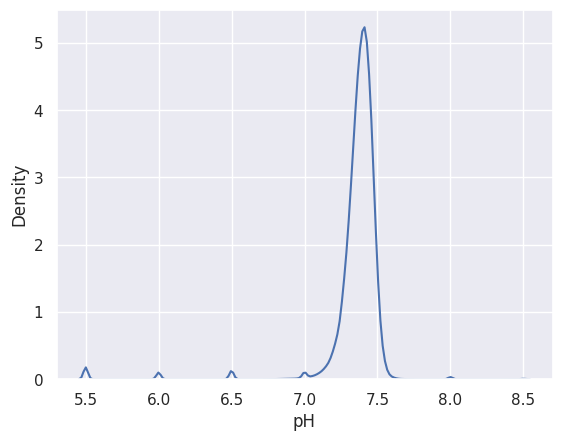

In [175]:
sns.kdeplot(vals_replaced[(vals_replaced < 9) & (vals_replaced > 5)])

In [176]:
vals_replaced.mean()

7.348869772751987